## Common Machine Learning Techniques with R
### Note - The purpose of this notebook is a quick reference for implementation and will very little EDA.
Source: This is a showcase/reference of projects completed during the Udemy course by Jose Portilla listed below </br>
https://www.udemy.com/share/1013iKCEISeFtaQ3g=/

## Linear Regression 

In [65]:
library('car')
library('ggplot2')

Warning message:
"package 'ggplot2' was built under R version 3.6.3"


In [1]:
bike <- read.csv('data//bikeshare.csv')

In [2]:
# This dataset considers the various factors for someone choosing to rent a bike with count (number of bikes rented) 
# as the response variable
head(bike, 3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32


In [3]:
# Converting the datetime column to a datetime variable
bike$datetime <- as.POSIXct(bike$datetime)

In [4]:
# Badass correlation
cor(bike[, c('temp','count')])

,temp,count
temp,1.0000000,0.3944536
count,0.3944536,1.0000000


In [5]:
# Creating an hour variable for time
bike$hour <- sapply(bike$datetime,function(x){format(x,"%H")})

In [7]:
# building the base model (only count and temperature)
temp.model <- lm(count ~ temp, data = bike)
summary(temp.model)


Call:
lm(formula = count ~ temp, data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-293.32 -112.36  -33.36   78.98  741.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0462     4.4394   1.362    0.173    
temp          9.1705     0.2048  44.783   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 166.5 on 10884 degrees of freedom
Multiple R-squared:  0.1556,	Adjusted R-squared:  0.1555 
F-statistic:  2006 on 1 and 10884 DF,  p-value: < 2.2e-16


In [8]:
# Predicting with the current model for a temp of 25
temp.test <- data.frame(temp=c(25))
predict(temp.model,temp.test,interval='confidence')

,fit,lwr,upr
1,235.3097,231.6429,238.9765


In [9]:
# Considering all of the features to build the model and converting some to factors
temp.model.full <- lm(count ~ temp + factor(season) + holiday + workingday + factor(weather) + 
                      temp + humidity + windspeed + factor(hour), data = bike)

In [10]:
# Getting the summary
summary(temp.model.full)


Call:
lm(formula = count ~ temp + factor(season) + holiday + workingday + 
    factor(weather) + temp + humidity + windspeed + factor(hour), 
    data = bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-356.78  -60.70   -9.92   50.52  510.17 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -22.0757     8.1608  -2.705 0.006840 ** 
temp                6.6150     0.2427  27.254  < 2e-16 ***
factor(season)2    36.5796     3.9204   9.330  < 2e-16 ***
factor(season)3    17.2650     5.0127   3.444 0.000575 ***
factor(season)4    65.3580     3.2409  20.167  < 2e-16 ***
holiday            -7.5590     6.5472  -1.155 0.248303    
workingday          1.0284     2.3430   0.439 0.660719    
factor(weather)2   -6.3323     2.6037  -2.432 0.015029 *  
factor(weather)3  -64.6746     4.3988 -14.703  < 2e-16 ***
factor(weather)4 -129.2514   110.2378  -1.172 0.241031    
humidity           -0.9539     0.0740 -12.890  < 2e-16 ***
windspeed          -0.7

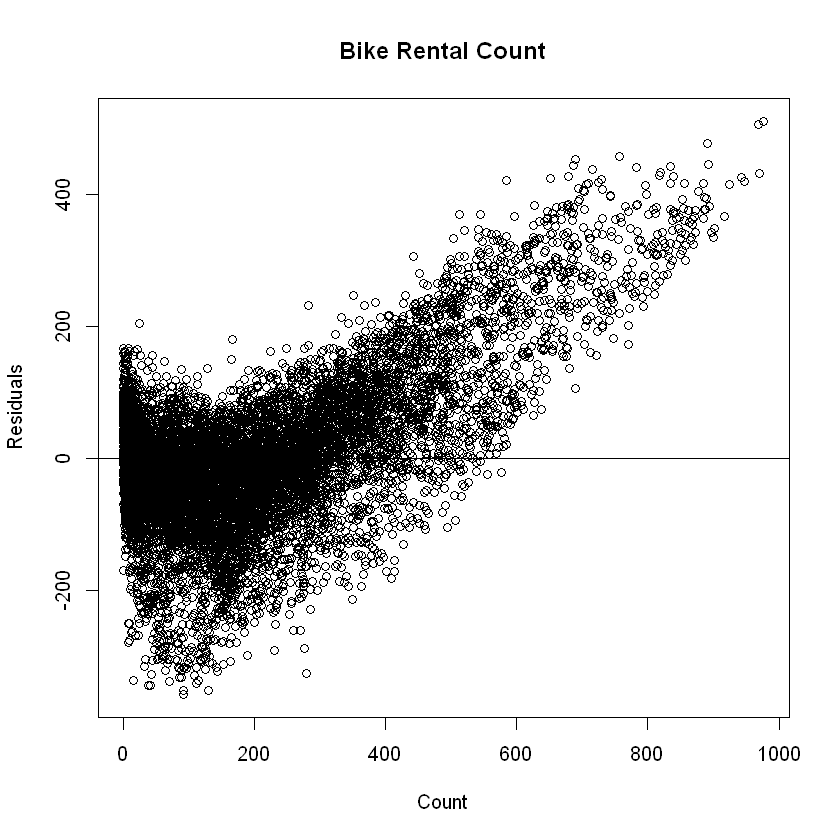

In [14]:
# Getting residuals
residuals <- resid(temp.model.full)

# Plotting them
plot(bike$count, residuals, ylab="Residuals", xlab="Count", main="Bike Rental Count")
abline(0,0)

[1] 9298 9346

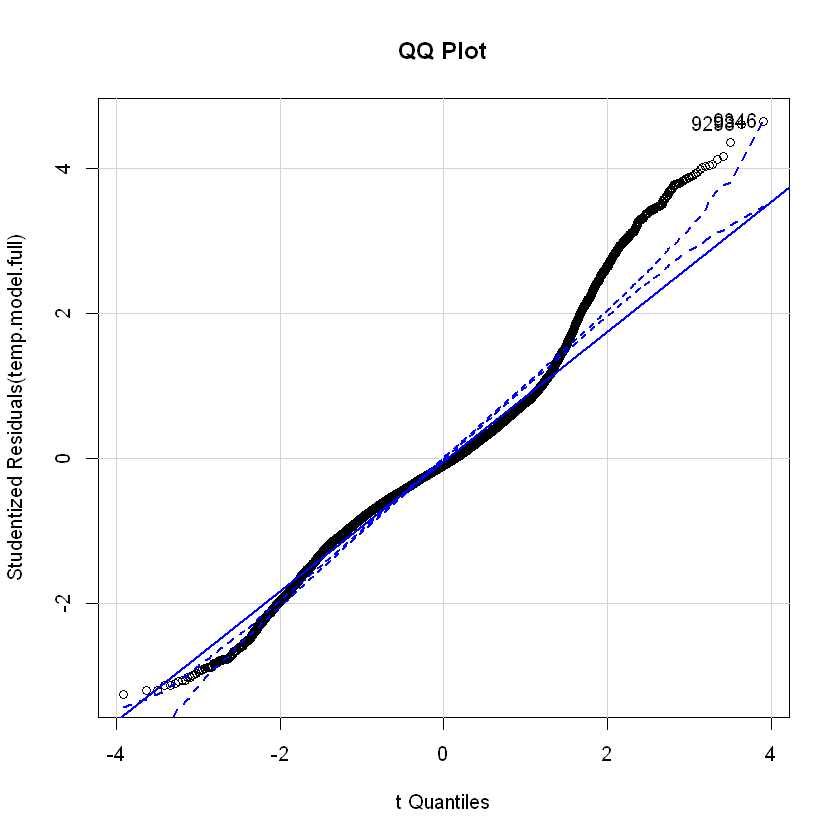

In [19]:
# Doing a qq plot to check normality.
qqPlot(temp.model.full, main="QQ Plot")

## Logistic Regression (w/some feature engineering)

In [107]:
adult <- read.csv('data//adult_sal.csv')

In [108]:
head(adult,3)

,X,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
,<int>,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [109]:
# dropping the X column
library(dplyr)
adult <- select(adult,-X)

ERROR: Error in select(adult, -X): unused argument (-X)


In [110]:
# data cleaning
table(adult$type_employer)


               ?      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

In [111]:
# Combining never worked and without pay
unemp <- function(job){
    job <- as.character(job)
    if (job=='Never-worked' | job=='Without-pay'){
        return('Unemployed')
    }else{
        return(job)
    }
}

In [112]:
adult$type_employer <- sapply(adult$type_employer,unemp)

In [113]:
# Combining job functions
unemp2 <- function(job){
    job <- as.character(job)
    if (job=='State-gov' | job=='Local-gov'){
        return('SL-emp')
    } else if (job == 'Self-emp-inc' | job == 'Self-emp-not-inc'){
        return('self-emp')
    }else{
        return(job)
    }
}

In [114]:
adult$type_employer <- sapply(adult$type_employer,unemp2)

In [115]:
# Combining marital status
group_marital <- function(mar){
    mar <- as.character(mar)
    
    # Not-Married
    if (mar=='Separated' | mar=='Divorced' | mar=='Widowed'){
        return('Not-Married')
    
    # Never-Married   
    }else if(mar=='Never-married'){
        return(mar)
    
     #Married
    }else{
        return('Married')
    }
}

In [116]:
adult$marital <- sapply(adult$marital,group_marital)

In [117]:
# Grouping cournties into regions
Asia <- c('China','Hong','India','Iran','Cambodia','Japan', 'Laos' ,
          'Philippines' ,'Vietnam' ,'Taiwan', 'Thailand')

North.America <- c('Canada','United-States','Puerto-Rico' )

Europe <- c('England' ,'France', 'Germany' ,'Greece','Holand-Netherlands','Hungary',
            'Ireland','Italy','Poland','Portugal','Scotland','Yugoslavia')

Latin.and.South.America <- c('Columbia','Cuba','Dominican-Republic','Ecuador',
                             'El-Salvador','Guatemala','Haiti','Honduras',
                             'Mexico','Nicaragua','Outlying-US(Guam-USVI-etc)','Peru',
                            'Jamaica','Trinadad&Tobago')
Other <- c('South')

group_country <- function(ctry){
    if (ctry %in% Asia){
        return('Asia')
    }else if (ctry %in% North.America){
        return('North.America')
    }else if (ctry %in% Europe){
        return('Europe')
    }else if (ctry %in% Latin.and.South.America){
        return('Latin.and.South.America')
    }else{
        return('Other')      
    }
}

In [118]:
adult$country <- sapply(adult$country,group_country)

In [119]:
# Renaming country to region
head(adult %>% rename(region = country),3)

,X,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,region,income
,<int>,<int>,<chr>,<int>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<chr>,<fct>
1,1,39,SL-emp,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,North.America,<=50K
2,2,50,self-emp,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,North.America,<=50K
3,3,38,Private,215646,HS-grad,9,Not-Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,North.America,<=50K


In [120]:
# Missing Data w/Amelia
library('Amelia')

In [121]:
# Converting ? to NA
adult[adult == '?'] <- NA

In [122]:
# Omitting N/As
adult <- na.omit(adult)

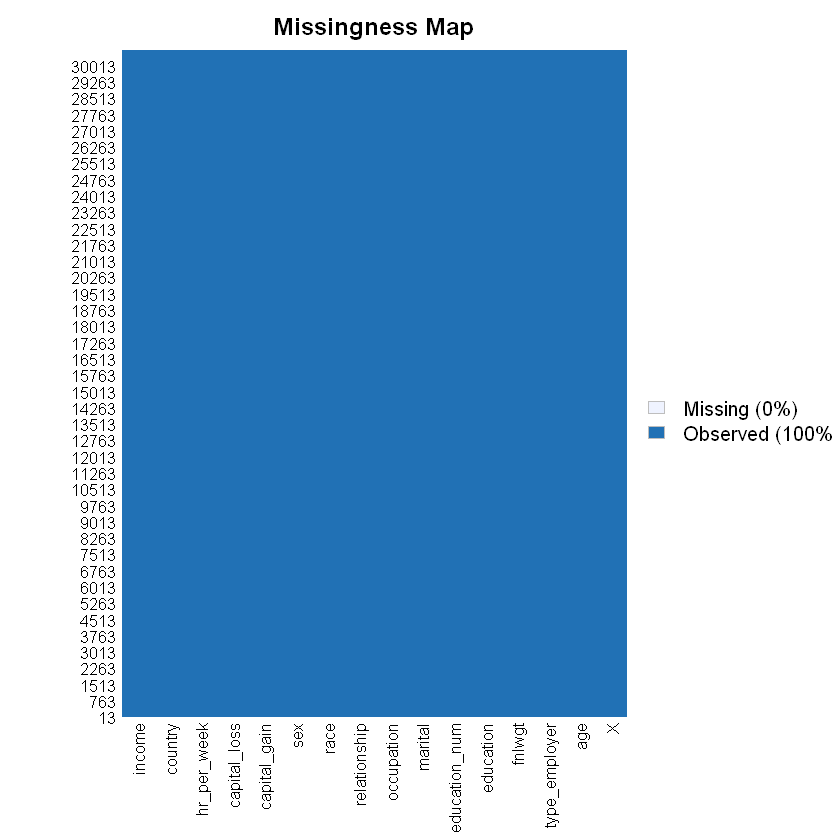

In [123]:
missmap(adult)

### Train/Test Split w/CA Tools

In [124]:
# Import Library
library(caTools)

# Set a random see so your "random" results are the same as this notebook
set.seed(101) 

# Split up the sample, basically randomly assigns a booleans to a new column "sample"
sample <- sample.split(adult$income, SplitRatio = 0.70) # SplitRatio = percent of sample==TRUE

# Training Data
train = subset(adult, sample == TRUE)

# Testing Data
test = subset(adult, sample == FALSE)

In [125]:
# Building the model
model = glm(income ~ ., family = binomial(logit), data = train)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [126]:
# Confusion Matrix
test$predicted.income = predict(model, newdata=test, type="response")
table(test$income, test$predicted.income > 0.5)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


       
        FALSE TRUE
  <=50K  6374  546
  >50K    874 1421

In [127]:
# Accuracy
accuracy = (6372+1423)/(6372+1423+548+872)
sprintf("Model Accuracy is %f", accuracy)

# Precision
precision = 6732/(6372+872)
sprintf("Model precision is %f", precision)

# Recall 
recall = 6732/(6372+548)
sprintf("Model recall is %f", recall)

[1] "Model Accuracy is 0.845903"

[1] "Model precision is 0.929321"

[1] "Model recall is 0.972832"

In [128]:
library(arm)

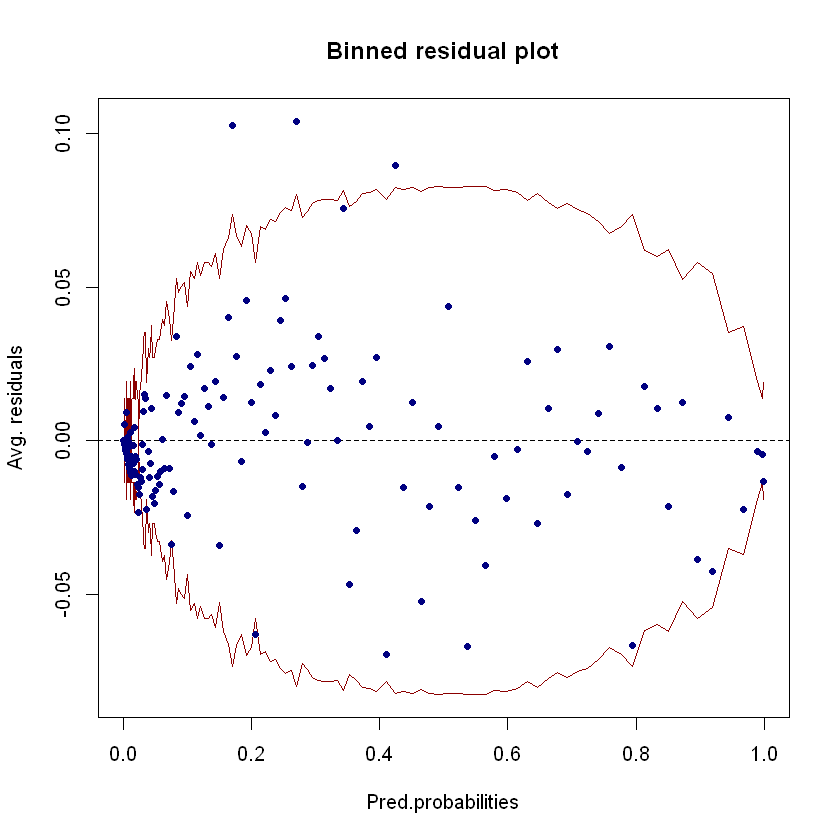

In [129]:
binnedplot(fitted(model),residuals(model,"resp"),xlab="Pred.probabilities",col.int="red4", ylab="Avg. residuals",main="Binned residual plot",col.pts="navy")

### Roc Curve

Setting levels: control = <=50K, case = >50K

Setting direction: controls < cases



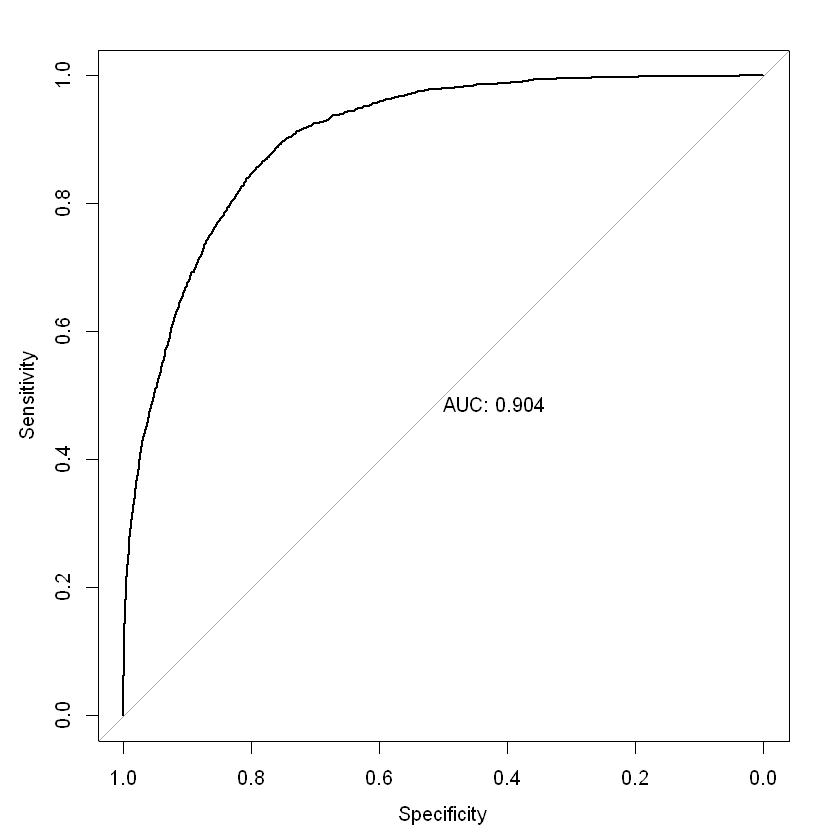

In [135]:
library(pROC)
test_roc = roc(test$income ~ test$predicted.income, plot = TRUE, print.auc = TRUE)

## KNN 
### Using the iris dataset

In [53]:
library("ISLR")

Warning message:
"package 'ISLR' was built under R version 3.6.3"


In [54]:
head(iris, 3)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa


In [55]:
# Remember to use KNN you first have to scale the data
iris.scaled <- scale(iris[,-5])

# Checking the variance
var(iris.scaled[,1])

[1] 1

In [56]:
# Rejoining the output with the standardized dataframe
# Selecting the flower type
flower.type <- iris[,5]

# # Putting it into a Dataframe
flower.type <- data.frame(flower.type)

# Column binding with the scaled data 
iris.working <- cbind(iris.scaled, flower.type)

head(iris.working,3)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,flower.type
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-0.8976739,1.0156020,-1.335752,-1.311052,setosa
2,-1.1392005,-0.1315388,-1.335752,-1.311052,setosa
3,-1.3807271,0.3273175,-1.392399,-1.311052,setosa


In [57]:
# Train/Test split using the caTools library
set.seed(101)

sample <- sample.split(iris.working$flower.type, SplitRatio = .70)
train <- subset(iris.working, sample == TRUE)
test <- subset(iris.working, sample == FALSE)

In [60]:
# Building the knn with the class library
library('class')

# K = 1
predicted.species <- knn(train[1:4],test[1:4],train$flower.type,k=1)

Warning message:
"package 'class' was built under R version 3.6.3"


In [61]:
#predicted.species
v <- mean(test$flower.type != predicted.species) # Error rate calculation
print(paste0("The misclasification rate was ", v))

[1] "The misclasification rate was 0.0444444444444444"


### The "Elbow Method" for KNN

In [62]:
# For loop over values of k
predicted.purchase = NULL
error.rate = NULL

for(i in 1:10){
    set.seed(101)
    predicted.species = knn(train[1:4],test[1:4],train$flower.type,k=i)
    error.rate[i] = mean(test$flower.type != predicted.species)
}

In [63]:
# Creating a K Values DF
k.values <- 1:10
df <- data.frame(k.values, error.rate)

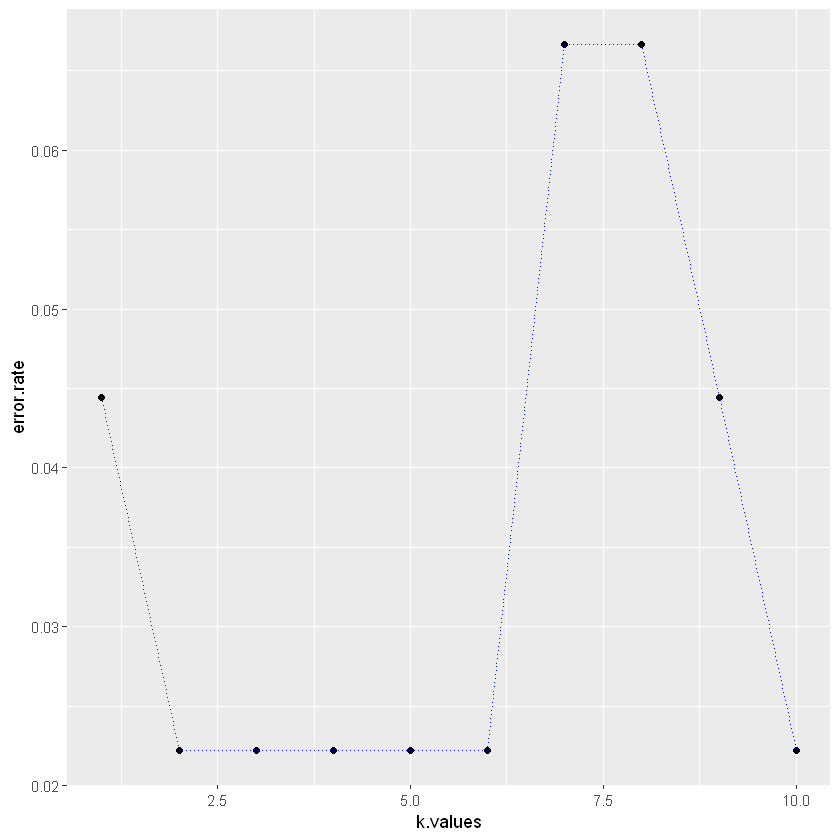

In [66]:
# Plotting (K between 2-6 works the best)
ggplot(df, aes(x = k.values, error.rate)) + geom_point() + geom_line(lty = 'dotted', color = 'blue')

## Decision Trees/Random Forest

In [78]:
# Using the College DF from the ISLR library
df <- College
head(df,3)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54


In [79]:
# Removing one outlier that had over 100% grad rate
df[c('Cazenovia College'),]$Grad.Rate = 100

In [80]:
# Train Test Split
set.seed(101)

split = sample.split(df$Private, SplitRatio = 0.70)

final.train = subset(df, split == TRUE)
final.test = subset(df, split == FALSE)

In [81]:
# Building a decision tree with the rpart library
library('rpart')
tree <- rpart(Private ~ ., method ='class', data = final.train)

In [82]:
# Making predictions
tree.preds <- predict(tree, final.test)

In [84]:
head(tree.preds,3)

,No,Yes
Adrian College,0.003311258,0.9966887
Alfred University,0.003311258,0.9966887
Allegheny College,0.003311258,0.9966887


In [85]:
# Attaching the private label 
tree.preds <- as.data.frame(tree.preds)
joiner <- function(x){
    if (x>=0.5){
        return('Yes')
    }else{
        return("No")
    }
}

In [86]:
tree.preds$Private <- sapply(tree.preds$Yes,joiner)
head(tree.preds, 3)

,No,Yes,Private
,<dbl>,<dbl>,<chr>
Adrian College,0.003311258,0.9966887,Yes
Alfred University,0.003311258,0.9966887,Yes
Allegheny College,0.003311258,0.9966887,Yes


In [87]:
# Confusion Matrix
table(tree.preds$Private, final.test$Private)

     
       No Yes
  No   57   9
  Yes   7 160

Warning message:
"package 'rpart.plot' was built under R version 3.6.3"


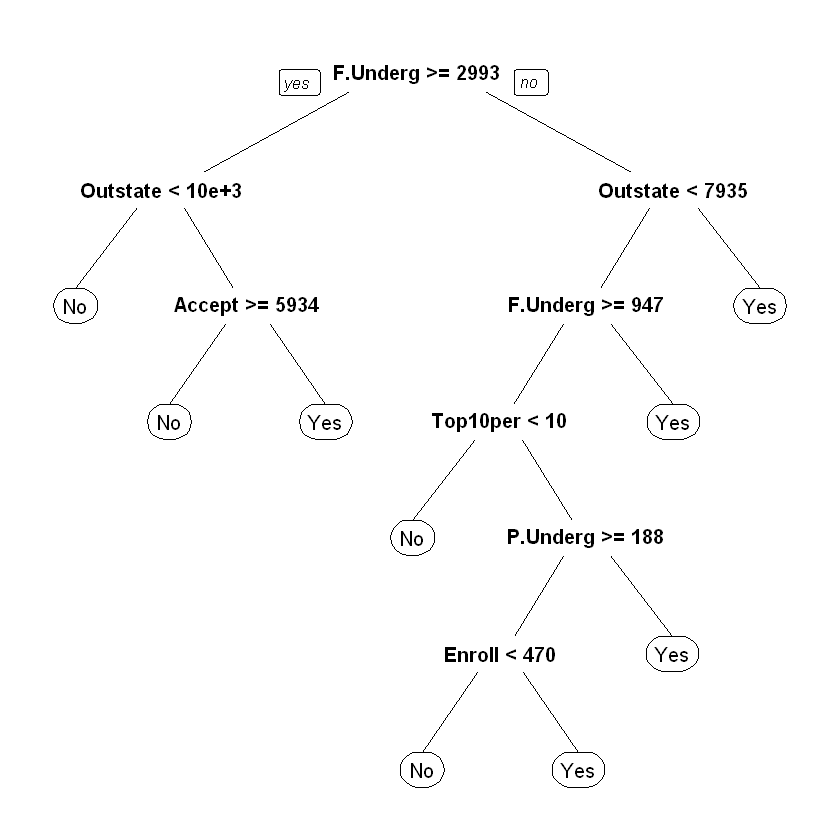

In [88]:
# Plotting the tree with the rpart library
library(rpart.plot)
prp(tree)

In [89]:
# Sample problem using random forest
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




In [90]:
randForest <- randomForest(Private ~ ., data = final.train)

In [91]:
randForest$importance

,MeanDecreaseGini
Apps,9.115058
Accept,12.877181
Enroll,21.203437
Top10perc,5.290634
Top25perc,4.449940
F.Undergrad,41.842334
P.Undergrad,14.757270
Outstate,41.256178
Room.Board,11.805328
Books,2.155344


In [92]:
# Building the confusion matrix
randForestPredictions <- predict(randForest,final.test)
table(randForestPredictions, final.test$Private)

                     
randForestPredictions  No Yes
                  No   55   7
                  Yes   9 162

## Support Vecotr Machines 

In [137]:
# Inputting the data
loans <- read.csv('data//loan_data.csv')

# Converting to factor variables
loans$inq.last.6mths <- as.factor(loans$inq.last.6mths)
loans$delinq.2yrs <- as.factor(loans$delinq.2yrs)
loans$pub.rec <- as.factor(loans$pub.rec)
loans$not.fully.paid <- as.factor(loans$not.fully.paid)
loans$credit.policy <- as.factor(loans$credit.policy)

In [138]:
# Splitting into train and test. We will be seeing if someone is likely to default on their loans
set.seed(101) 

sample = sample.split(loans$not.fully.paid, SplitRatio = .70)
train = subset(loans, sample == TRUE)
test = subset(loans, sample == FALSE)

In [139]:
# Building a model with the e1071 library
library(e1071)

# Building the model
model <- svm(not.fully.paid ~ . , data = train)

# Printing the summary
summary(model)

Warning message:
"package 'e1071' was built under R version 3.6.3"



Call:
svm(formula = not.fully.paid ~ ., data = train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  2849

 ( 1776 1073 )


Number of Classes:  2 

Levels: 
 0 1




In [140]:
# Predicting and printing values
predicted.values <- predict(model, test[1:13])

table(predicted.values, test$not.fully.paid)

                
predicted.values    0    1
               0 2413  460
               1    0    0

### A best practice is to "tune" the model where R will test out different cost and gamma values
### THIS TAKES A WHILE

In [141]:
tune.results <- tune(svm,train.x=not.fully.paid~., data=train,kernel='radial',
                  ranges=list(cost=c(1,10), gamma=c(0.1,1)))

summary(tune.results)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.1

- best performance: 0.1600305 

- Detailed performance results:
  cost gamma     error dispersion
1    1   0.1 0.1600305 0.01381824
2   10   0.1 0.1709175 0.01488162
3    1   1.0 0.1607759 0.01421531
4   10   1.0 0.1785250 0.01462696


In [142]:
model <- svm(not.fully.paid ~ .,data=train,cost=10,gamma = 0.1)
predicted.values <- predict(model,test[1:13])
table(predicted.values,test$not.fully.paid)

                
predicted.values    0    1
               0 2350  425
               1   63   35

## K Means Clustering

In [143]:
# Reading in the DFs
df1 <- read.csv('data//winequality-red.csv', sep =';')
df2 <- read.csv('data//winequality-white.csv', sep =';')

# Adding red and white labels
df1$label = 'red'
df2$label = 'white'

# Combining into a single DF
wine <- rbind(df1,df2)

In [144]:
# Getting the non labeled wine
clus.data <- wine[,1:12]

In [145]:
# Clustering the wine
wine.cluster <- kmeans(wine[1:12],2)

# Printing
print(wine.cluster$centers)

  fixed.acidity volatile.acidity citric.acid residual.sugar chlorides
1      6.904698        0.2871364   0.3398094       7.259286 0.0486092
2      7.619044        0.4079451   0.2911080       3.082690 0.0656846
  free.sulfur.dioxide total.sulfur.dioxide   density       pH sulphates
1            39.82503            155.90101 0.9947956 3.190308 0.5000354
2            18.43735             63.54832 0.9945680 3.255147 0.5718655
   alcohol  quality
1 10.25832 5.825436
2 10.79529 5.809204


In [149]:
table(wine$label, wine.cluster$cluster)

       
           1    2
  red     84 1515
  white 3588 1310

## Neural Nets

In [153]:
# Reading in the Dataframe
bank <- read.csv('data//bank_note_data.csv')

# Predicting class
head(bank, 3)

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,3.6216,8.6661,-2.8073,-0.44699,0
2,4.5459,8.1674,-2.4586,-1.46210,0
3,3.8660,-2.6383,1.9242,0.10645,0


In [154]:
# Train Test split
split = sample.split(bank$Class, SplitRatio = 0.70)

train = subset(bank, split == TRUE)
test = subset(bank, split == FALSE)

In [155]:
# Calling the library
library(neuralnet)

# Building the model
model <- neuralnet(Class ~ ., data = train, hidden = 10, linear.output = FALSE)

Warning message:
"package 'neuralnet' was built under R version 3.6.3"

Attaching package: 'neuralnet'


The following object is masked from 'package:dplyr':

    compute




In [158]:
# Getting the predicted values and applying them to predictions
predicted.values <- compute(model, test[1:4])
predictions <- sapply(predicted.values$net.result,round)

In [159]:
# Printing the confusion matrix
table(predictions, test$Class)

           
predictions   0   1
          0 229   0
          1   0 183

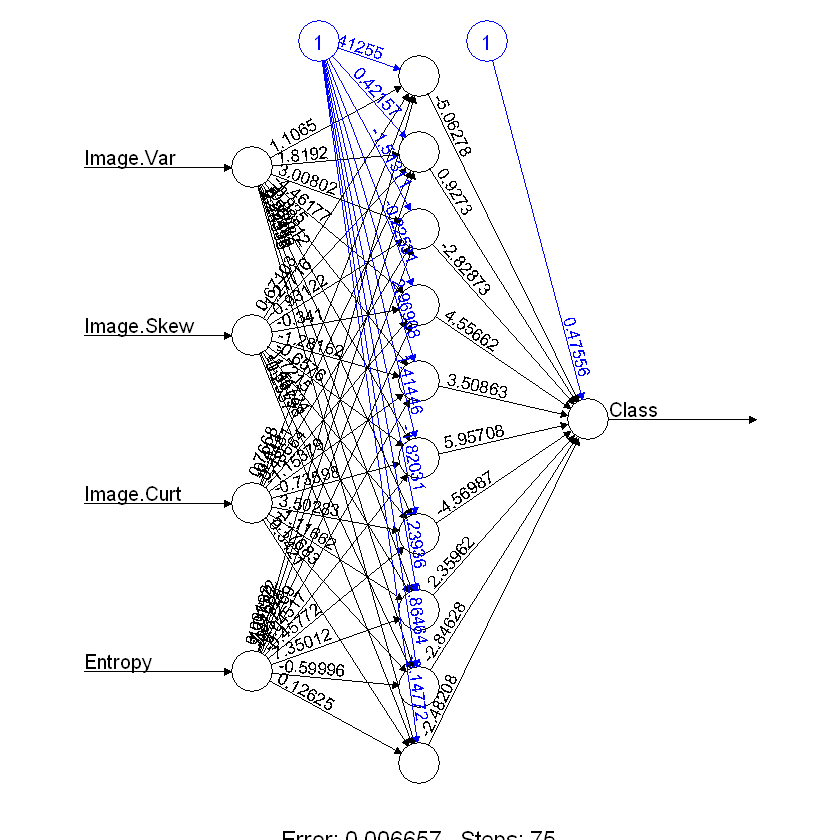

In [160]:
# A cool plot of the neural net
plot(model,rep='best')